## PyTorch for PINN tutorial

1. This is a tutorial that will cover the basic concepts required while working with Physics-informed Neural Networks (PINN) with the PyTorch package
2. We will solve the "supervised" learning problem of fitting a sine wave using a NN and then compute the "unsupervised derivative" using the NN (The derivative is "unsupervised" as the NN has not learnt what derivatives are in this framework)
3. Equipped with a basic understanding of how to compute derivatives, we will set up "custom loss-functions" involving derivatives to solve a simple first-order ODE
4. We will build on our first-order ODE PINN framework to solve a simple second-order ODE

## Why do we want to compute derivatives and solve simple ODEs using a NN?

1. In many cases, we might be interested in fitting experimental data to physical laws involving derivatives. However, if experimental data corresponding to the derivatives is not available, numerical differentiation needs to be carried out and it is well known that this introduces "numerical noise" into the system. Neural Networks are "nice" functions, meaning that they are well-behaved, bounded, continuous and differentiable. Thus, the NN framework might be suitable for numerical differentiation and is also a verstaile framework that allows for easy incorporation of derivative-based loss functions
2. Once we understand how the solution to simple toy problems can be conceptualized using a NN, we can then abstract this NN framework to complicated problems involving derivative-based loss functions
3. As a concrete example, the differential equation for a simple pendulum is NOT always solvable analytically for large angles
4. In Physics and Engineering, we are often interested in understanding the "cause" given an "observable effect". This class of problems is called "inverse problems". Often times, we have "limited information" about the "effect" and we need to back out the cause. This is like trying to describe a dragon from its tracks

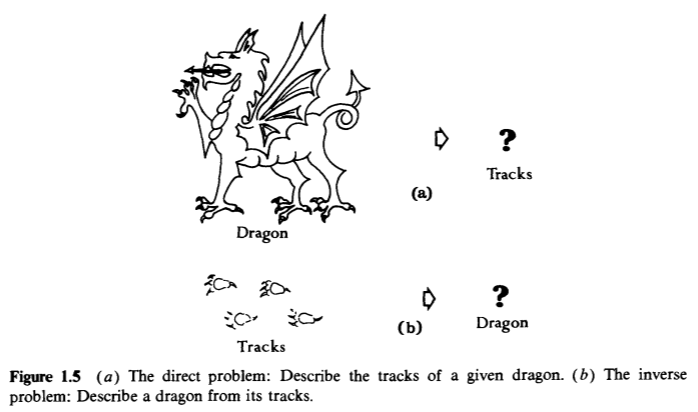

5. For such inverse problems, we might start with the effect and have a "black-box function" transform the "effect" to the "cause". We can then pass the "cause" to our simple "forward model" and "reconstruct" the effect. If our workflow can "correctly reconstruct" the effect, we then might be able to recover the "cause". We would however need a "black-box function" that can iteratively learn and guess the right answer. This is where a NN with a custom loss-function comes in handy and the workflow described is visualized below

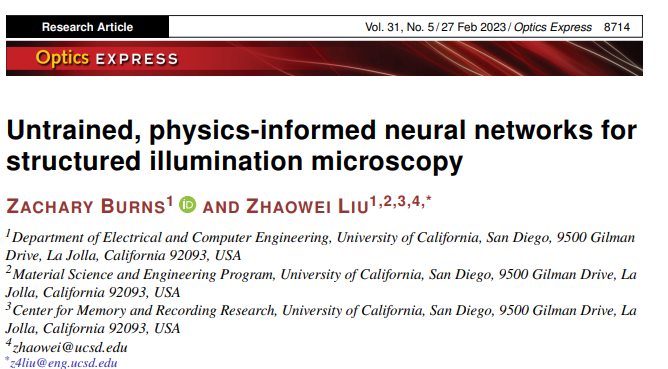

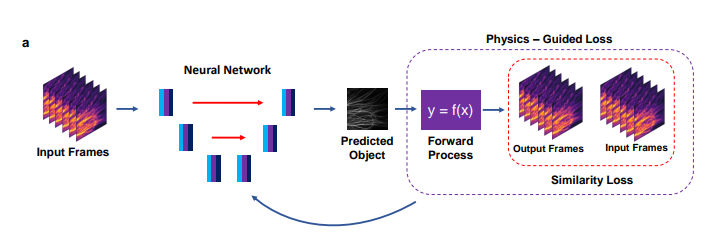

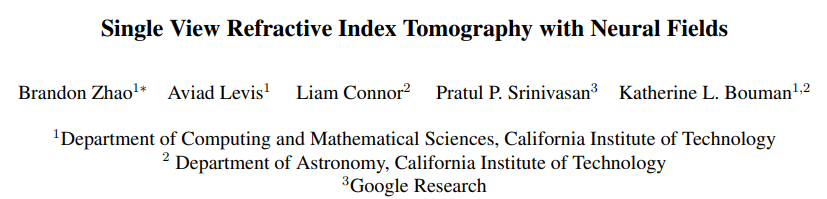

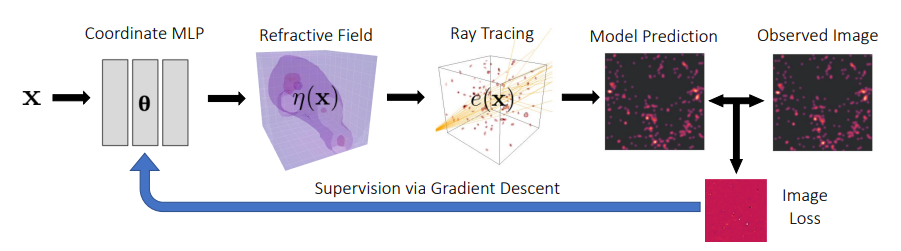

## Import relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Command to set device preference to GPU

1. GPU stands for "Graphical Processing Unit" and the GPU is capable of speeding up computations by carrying out multiple calculations simultaneously
2. The Python command below is an example where the "ternary operator" is being used

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Simple example of ternary operator

In [3]:
int_1 = 10
int_2 = 20
int_max = int_1 if int_1 > int_2 else int_2
print(int_max)

20


## Computing "unsupervised" derivatives using NN

$$ y = \sin(x)$$

$$ y^{'} = \cos(x)$$

$$ x \in [-\pi, \pi]$$

## Define NN

1. Note that our "design choice" is arbitrary
2. Our focus in this tutorial will be on learning how to compute derivatives and set up custom loss functions involving derivatives, given a network architecture
3. The nn.Module is a fundamental building block in PyTorch for creating Neural Networks and therefore, all custom PyTorch modules should build on nn.Module by inheriting from it
4. The "super().." part ensures that the initialization protocol required by the Parent class is completed
5. The "init" part creates the "network skeleton" by specifying the "number of layers" and "number of neurons in each layer"
6. Here, we have a NN with an input layer designed for a single feature, 3 hidden layers with 10 neurons each and an output designed again, for a single feature
7. Note that we do not provide the input layer specifications explicitly in PyTorch
8. The "forward" method executes a "forward pass" on being called and uses the sigmoid activation function
9. Note that, again, the choice of the activation function is arbitrary just like all the other design choices made

In [4]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer_1 = nn.Linear(1, 10)
        self.hidden_layer_2 = nn.Linear(10, 10)
        self.hidden_layer_3 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.sigmoid(self.hidden_layer_1(x))
        x = torch.sigmoid(self.hidden_layer_2(x))
        x = torch.sigmoid(self.hidden_layer_3(x))
        output = self.output_layer(x)
        return output

## Simple example of the "super" command

In [5]:
class Parent:
    def __init__(self, name):
        self.name = name

class Child(Parent):
    def __init__(self, name, age):
        # Call the constructor of the parent class
        super().__init__(name)
        self.age = age

# Create an instance of the Child class
child = Child("Alice", 5)

# Access attributes of both Parent and Child
print("Name:", child.name)
print("Age:", child.age)

Name: Alice
Age: 5


## Detailed explanation of the "super" command example (Optional)

1. There are two classes, "Parent" and "Child". "Child" is inheriting from Parent
2. The "Parent" class has an "__init__" method that takes a "name" argument and sets an instance variable "name"
3. The Child class has its own "__init__" method that takes both "name" and "age" arguments
4. When we create an instance of the "Child" class, as shown in the code, it inherits the "name" attribute from the "Parent" class and sets its "age" attribute. The "super().__init__()" call ensures that the initialization logic in the parent class is executed before the child class-specific initialization, allowing you to build on and extend the functionality of the parent class.

## Initialize NN

In [6]:
Nd = Network()
Nd = Nd.to(device)

## MSE Loss Function

MSE stands for "Mean-Squared Error"

In [7]:
def loss_mse(x,y):
    y_pred = Nd(x)
    
    return torch.mean( (y-y_pred)**2 )

## Create toy data

1. We are using the "mathy" torch commands to initialize and work with all the "mathy" stuff!
2. The torch "mathy stuff" is very similar to the "numpy stuff" except that torch tensors have GPU support and can be automatically differentiated

In [8]:
xd = torch.linspace(-np.pi, np.pi, 100)[:, None]
yd = torch.sin(xd)

## What does "None" do?

The ":, None' part ensures that the torch tensor is a "column vector"

In [9]:
xd_wo_none = torch.linspace(-np.pi, np.pi, 100)
xd_wo_none.shape

torch.Size([100])

In [10]:
xd_w_none = torch.linspace(-np.pi, np.pi, 100)[:, None]
xd_w_none.shape

torch.Size([100, 1])

## Check the shape of xd and yd

In [11]:
xd.shape

torch.Size([100, 1])

In [12]:
yd.shape

torch.Size([100, 1])

## Train NN

1. The NN is trained using the LBFGS optimizer
2. The LBFGS optimizer is a popular numerical algorithm used for unconstrained optimization problems and stands for "Limited-memory Broyden-Fletcher-Goldfarb-Shanno"
3. The choice of the LBFGS optimizer was again arbitrary just like the NN architecture, the reason being that the focus of this tutorial is not choosing the "optimal optimizer". That being said, in retrospect, the LBFGS optimizer is known to be globally convergent (convergence guaranteed independent of starting point) and is well-suited for a well-behaved loss-function landscape, which we have here!
4. The gradients are initialized to zero using the "optimizer.zero_grad()" command. This prevents "incorrect model updates" that could result from "gradient accumulation"
5. The closure function is designed to do a single step of backpropagation
6. The name "closure" is a popular choice in scientific computing and refers to a "self-contained" code block that abstracts the computations pertaining to the objective function and gradients, thus "closing" computations related to objective functions and gradients 
7. The for loop at the end of the code block trains the NN over multiple epochs by iteratively doing backpropagation using the closure function
8. An "epoch" refers to one complete pass through the entire dataset

In [13]:
optimizer = torch.optim.LBFGS(Nd.parameters())

def closure():
    optimizer.zero_grad()
    l = loss_mse(xd,yd)
    l.backward()

    return l

epochs = 100
for i in range(epochs):
    optimizer.step(closure)

## Generate NN prediction

1. Since, we are not computing derivatives below, we use "torch.no_grad()"
2. "torch.no_grad()" might not be strictly required but since we are making a prediction and do not require gradient computations, using "torch.no_grad()" will save memory, processing time and is therefore, good practice!

In [14]:
xx = torch.linspace(-np.pi, np.pi, 100)[:, None]
with torch.no_grad():
    yy = Nd(xx)

## Define function for computing first derivative using automatic differentiation

1. Setting the "requires_grad" flag to "True for the tensor "x" informs PyTorch that we want to compute gradients with respect to "x"
2. In summary, for our purposes here, "x.requires_grad = True" enables "automatic differentiation"
3. The ".sum()" is required while computing the gradient of scalar-valued functions. Recall, that we are solving a single-variable (scalar-valued) regression problem using a NN
4. Setting the "create_graph" flag to "True", informs PyTorch to create a computation graph that keeps track of the operations performed on tensors
5. The result of using torch.autograd.grad is a tuple containing the gradient. The "0" index is used to extract the gradient tensor

In [15]:
def first_derivative(x, NN):
    x.requires_grad = True
    y = NN(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    
    return dy_dx

## Compute first derivative

In [16]:
yy_prime = first_derivative(xx, Nd)

## Convert torch arrays to numpy array for plotting

In [17]:
yy_prime_plot = yy_prime.to('cpu').detach().numpy()
xx_plot = xx.to('cpu').detach().numpy()

1. "detach()" essentially detaches the tensor from the computational graph, meaning that we do not need to worry about gradient computations
2. Recall that while torch tensors can be automatically differentiated, the same does not hold true for numpy arrays and we are currently converting our torch tensors to numpy arrays for plotting purposes

## Compute true derivative

In [18]:
xt = np.arange(-np.pi, np.pi, 0.05)
xt = xt.reshape(-1,1)
yt_prime = np.cos(xt)

## Plot results for unsupervised derivative computed using automatic differentiation post-training of supervised NN

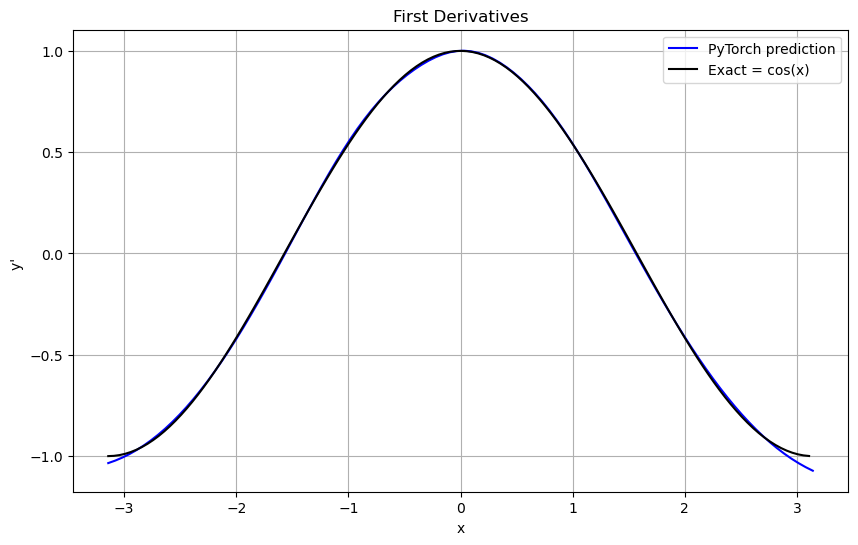

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(xx_plot, yy_prime_plot, 'b-', label="PyTorch prediction")
plt.plot(xt, yt_prime, 'k-', label="Exact = cos(x)")
plt.xlabel("x")
plt.ylabel("y' ")
plt.title("First Derivatives")
plt.legend()
plt.grid()
plt.show()

## Solving First-order ODEs with PyTorch

$$y^{'} + (1+x)y = 0$$

$$y(0) = 1$$

$$x \in [0, 10]$$

## Initialize NN for first-order ODE

In [20]:
N_ode_first = Network()
N_ode_first = N_ode_first.to(device)

## Mathematical form of Loss Function for first-order ODE

$$ \text{Let } j \text{ denote an instance} $$

$$ \text{Let } x_{j} \text{ be the instance-wise input} $$

$$ \text{Let } {y_{j}}^{'} \text{ be the first-derivative of the instance-wise output with respect to the instance-wise input}$$

$$ \text{Let } L_{j} \text{ be the instance-wise loss function} $$

$$ \text{Let } L \text{ be the total loss function} $$

$$ \text{Let } B \text{ be the boundary or initial condition term} $$

$$ \text{Then: } $$

$$ L_{j} = \frac{1}{2}{({y_{j}}^{'} + (1+x_{j})y_{j})}^2 $$

$$ \implies L = \frac{1}{n} \sum_{j=1}^{n} L_{j} + B $$

$$ \implies L = \frac{1}{n} \sum_{j=1}^{n} \frac{1}{2}{({y_{j}}^{'} + (1+x_{j})y_{j})}^2 + B $$

$$ \text{Now: } $$

$$ y(0) = 1 \implies B = \frac{1}{2}{(y(0) - 1)}^2 $$

$$ \implies L = \frac{1}{n} \sum_{j=1}^{n} \frac{1}{2}{({y_{j}}^{'} + (1+x_{j})y_{j})}^2 + \frac{1}{2}{(y(0) - 1)}^2 $$

$$ L = \frac{1}{n} \sum_{j=1}^{n} \frac{1}{2}{({y_{j}}^{'} + (1+x_{j})y_{j})}^2 + \frac{1}{2}{(y(0) - 1)}^2 $$

## Custom Loss Function for first-order ODE

In [21]:
def loss_ode_first(x):
    x.requires_grad = True
    y = N_ode_first(x)
    d1 = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    
    return torch.mean(0.5*(d1 + (1+x)*y)**2) + 0.5*(y[0, 0] - 1.)**2

## Train NN for first-order ODE

In [22]:
optimizer_ode_first = torch.optim.LBFGS(N_ode_first.parameters())

x_ode_first = torch.linspace(0, 10, 100)[:, None]

def closure_ode_first():
    optimizer_ode_first.zero_grad()
    l_ode_first = loss_ode_first(x_ode_first)
    l_ode_first.backward()

    return l_ode_first

epochs_ode_first = 100
for i_ode_first in range(epochs_ode_first):
    optimizer_ode_first.step(closure_ode_first)

## Exact solution for first-order ODE

$$\frac{dy}{dx} = -(1+x)y$$

$$\implies \frac{dy}{y} = -(1+x)dx$$

$$\implies y = ce^{-(x + \frac{1}{2}x^2)}$$

$$y(0) = c = 1 \implies y = e^{-(x + \frac{1}{2}x^2)}$$

$$y = e^{-(x + \frac{1}{2}x^2)}$$

## Plot results for first-order ODE

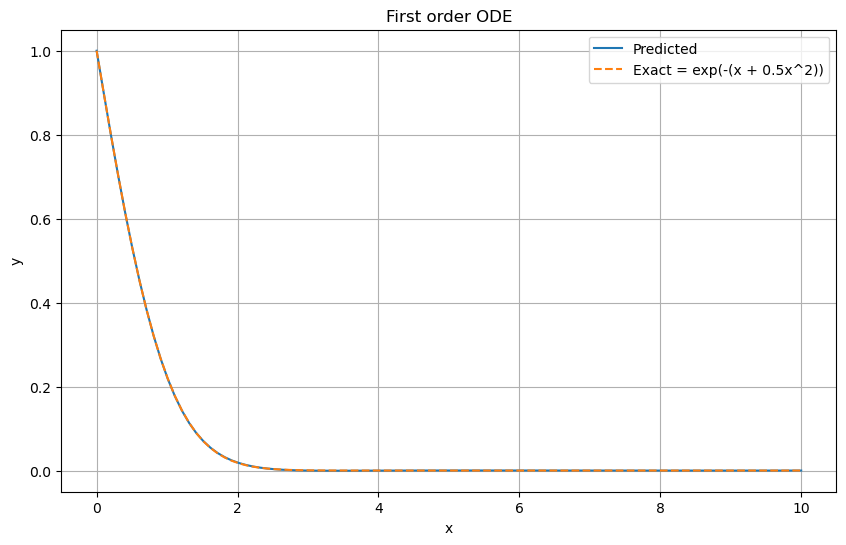

In [23]:
xx_ode_first = torch.linspace(0, 10, 100)[:, None]
with torch.no_grad():
    yy_ode_first = N_ode_first(xx_ode_first)

plt.figure(figsize=(10, 6))
plt.plot(xx_ode_first, yy_ode_first, label="Predicted")
plt.plot(xx_ode_first, torch.exp(-(xx_ode_first + 0.5*torch.square(xx_ode_first))), '--', label="Exact = exp(-(x + 0.5x^2))")
plt.xlabel('x')
plt.ylabel('y')
plt.title("First order ODE")
plt.legend()
plt.grid()

## Solving Second-order ODEs with PyTorch

$$y^{''} + 1 = 0$$

$$y(0) = 1$$

$$y^{'}(0) = 0$$

$$x \in [0, 2]$$

## Initialize NN for second-order ODE

In [24]:
N_ode_second = Network()
N_ode_second = N_ode_second.to(device)

## Mathematical form of Loss Function for second-order ODE

$$ \text{Let } j \text{ denote an instance} $$

$$ \text{Let } x_{j} \text{ be the instance-wise input} $$

$$ \text{Let } {y_{j}}^{'} \text{ be the first-derivative of the instance-wise output with respect to the instance-wise input}$$

$$ \text{Let } {y_{j}}^{''} \text{ be the second-derivative of the instance-wise output with respect to the instance-wise input} $$

$$ \text{Let } L_{j} \text{ be the instance-wise loss function} $$

$$ \text{Let } L \text{ be the total loss function} $$

$$ \text{Let } B \text{ be the boundary or initial condition term} $$

$$ \text{Then: } $$

$$ L_{j} = \frac{1}{2}{({y_{j}}^{''} + 1)}^2 $$

$$ \implies L = \frac{1}{n} \sum_{j=1}^{n} L_{j} + B $$

$$ \implies L = \frac{1}{n} \sum_{j=1}^{n} \frac{1}{2}{({y_{j}}^{''} + 1)}^2 + B $$

$$ \text{Now: } $$

$$ y(0) = 1 \text{ and } y^{'}(0) = 0 \implies B = \frac{1}{2}{(y(0) - 1)}^2 + \frac{1}{2}{(y^{'}(0) - 0)}^2 $$

$$ \implies L = \frac{1}{n} \sum_{j=1}^{n} \frac{1}{2}{({y_{j}}^{''} + 1)}^2 + \frac{1}{2}{(y(0) - 1)}^2 + \frac{1}{2}{(y^{'}(0) - 0)}^2 $$

$$ L = \frac{1}{n} \sum_{j=1}^{n} \frac{1}{2}{({y_{j}}^{''} + 1)}^2 + \frac{1}{2}{(y(0) - 1)}^2 + \frac{1}{2}{(y^{'}(0) - 0)}^2 $$

## Custom Loss Function for second-order ODE

In [25]:
def loss_ode_second(x):
    x.requires_grad = True
    y = N_ode_second(x)
    d1 = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    d2 = torch.autograd.grad(d1.sum(), x, create_graph=True)[0]
    
    return torch.mean(0.5*(d2 + 1)**2) + 0.5*(y[0, 0] - 1.)**2 + 0.5*(d1[0, 0] - 0.)**2

## Train NN for second-order ODE

In [26]:
optimizer_ode_second = torch.optim.LBFGS(N_ode_second.parameters())

x_ode_second = torch.linspace(0, 2, 100)[:, None]

def closure_ode_second():
    optimizer_ode_second.zero_grad()
    l_ode_second = loss_ode_second(x_ode_second)
    l_ode_second.backward()

    return l_ode_second

epochs_ode_second = 100
for i_ode_second in range(epochs_ode_second):
    optimizer_ode_second.step(closure_ode_second)

## Exact solution for second-order ODE

$$y^{''} + 1 = 0$$

$$\implies y^{'} = -x + c_{1}$$

$$y^{'}(0) = 0 \implies c_{1} = 0$$

$$\implies y^{'} = -x$$

$$\implies y = -\frac{1}{2}x^{2} + c_{2}$$

$$y(0) = 1 \implies c_{2} = 1$$

$$\implies y = 1 - \frac{1}{2}x^{2}$$

$$y(x) = 1 - \frac{1}{2}x^{2}$$

## Plot results for second-order ODE

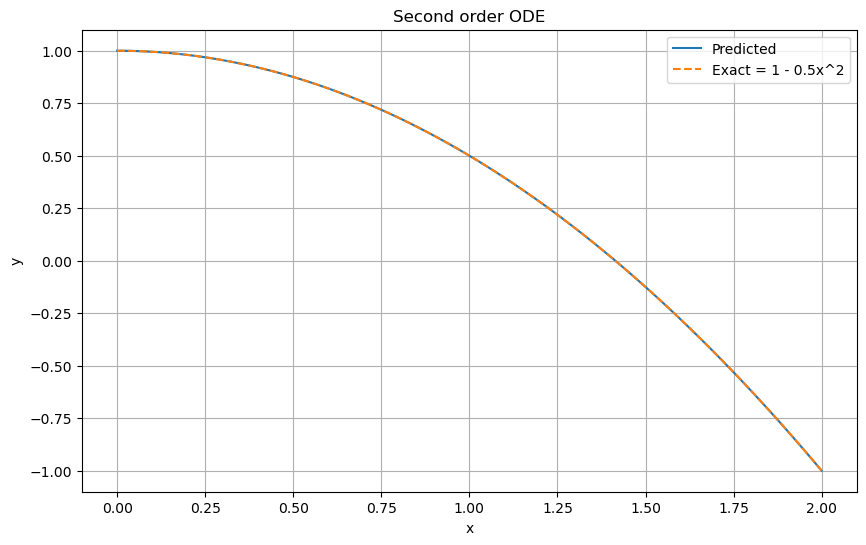

In [27]:
xx_ode_second = torch.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy_ode_second = N_ode_second(xx_ode_second)

plt.figure(figsize=(10, 6))
plt.plot(xx_ode_second, yy_ode_second, label="Predicted")
plt.plot(xx_ode_second, 1 - 0.5*torch.square(xx_ode_second), '--', label="Exact = 1 - 0.5x^2")
plt.xlabel('x')
plt.ylabel('y')
plt.title("Second order ODE")
plt.legend()
plt.grid()